# **Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19**

In [4]:
import torch
print(f"PyTorch версия: {torch.__version__}")
print(f"Доступ к GPU: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Имя GPU: {torch.cuda.get_device_name(0)}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    # Пример тензора на GPU
    x = torch.rand(3, 3, device="cuda")
    print(f"Тензор на GPU: {x.device}")
else:
    print("GPU недоступен. Работаем на CPU.")

PyTorch версия: 2.5.1+rocm6.2
Доступ к GPU: True
Имя GPU: AMD Radeon RX 7800 XT
Количество GPU: 1
Тензор на GPU: cuda:0


In [5]:
import pyspark

In [6]:
# Проверка Spark - объекта
print(pyspark)

# Проверка версии Spark
print(f"Spark Version: {pyspark.version}")

<module 'pyspark' from '/home/gna/anaconda3/envs/rocm/lib/python3.10/site-packages/pyspark/__init__.py'>
Spark Version: <module 'pyspark.version' from '/home/gna/anaconda3/envs/rocm/lib/python3.10/site-packages/pyspark/version.py'>


In [7]:
import os

# Проверяем текущую рабочую директорию
print("Текущая рабочая директория:", os.getcwd())

# Проверяем существование директории
print(f"\nДиректория существует: {os.path.exists('data/raw/covid-chestxray-dataset/')}")

# Проверяем существование файла
csv_file_path = 'data/raw/covid-chestxray-dataset/metadata.csv'
print(f"\nФайл существует: {os.path.exists(csv_file_path)}")

Текущая рабочая директория: /home/gna/workspase/education/MEPHI/covid-epi-image-analysis

Директория существует: True

Файл существует: True


In [8]:
# Интеграция модуля data_loader: Демонстрация загрузки данных
# Этот модуль обеспечивает единый интерфейс для загрузки медицинских данных
# из различных форматов (CSV, Parquet, JSON и др.)

import os
import sys
sys.path.append('/home/gna/workspase/education/MEPHI/covid-epi-image-analysis')

# Настройка переменной окружения SPARK_LOCAL_IP для привязки к локальному адресу
# Это решает проблемы с hostname и loopback адресами
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'

from pyspark.sql import SparkSession
from src.preprocessing.data_loader import load_dataset

# Инициализация Spark-сессии (если ещё не создана)
if 'spark' not in locals():
    spark = SparkSession.builder \
        .appName("COVID19_Metadata_Analysis") \
        .master("local[*]") \
        .config("spark.driver.host", "localhost") \
        .config("spark.driver.bindAddress", "127.0.0.1") \
        .config("spark.ui.port", "4040") \
        .config("spark.sql.shuffle.partitions", "4") \
        .getOrCreate()
    
    # Установка уровня логирования ERROR для подавления информационных предупреждений
    # Это подавляет большинство предупреждений после инициализации Spark
    spark.sparkContext.setLogLevel("ERROR")
    
    print("✓ Spark Session Ready")
else:
    print("✓ Spark Session Ready (already exists)")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/30 04:31:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/30 04:31:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/12/30 04:31:10 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/12/30 04:31:10 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


✓ Spark Session Ready


In [9]:
# Первоначальный исследовательский анализ данных для определения схемы
# ---------------------------------------------------------------------------
# Цель этого этапа:
# 1. Изучить структуру CSV-файла без предварительной схемы
# 2. Автоматически вывести типы данных с помощью Spark (inferSchema)
# 3. Понять, какие поля присутствуют и их типы
# 4. Использовать эту информацию для создания явной схемы в следующей ячейке

# ВНИМАНИЕ: Это первоначальный анализ данных для определения схемы.
# Используем inferSchema=True, что вызывает предупреждение из-за несоответствия
# количества заголовков и столбцов. В следующей ячейке мы создадим явную схему
# для устранения этого предупреждения.

import os
csv_file_path = 'data/raw/covid-chestxray-dataset/metadata.csv'

print("=" * 80)
print("ПЕРВОНАЧАЛЬНЫЙ АНАЛИЗ: Загрузка с автоматическим определением типов (inferSchema=True)")
print("=" * 80)

# Загрузка данных с автоматическим выводом схемы (для исследования)
df_inferred = spark.read.csv(
    csv_file_path,
    header=True,
    inferSchema=True
)

# Вывод автоматически выведенной схемы
print("\n--- Автоматически выведенная схема (Inferred Schema) ---")
df_inferred.printSchema()

# Показать первые 5 строк данных
print("\n--- Первые 5 строк данных ---")
df_inferred.show(5, truncate=False)

# Показать количество строк и столбцов
row_count = df_inferred.count()
col_count = len(df_inferred.columns)
print(f"\n--- Размеры датасета ---")
print(f"Количество строк: {row_count}")
print(f"Количество столбцов: {col_count}")

# Показать имена всех столбцов
print(f"\n--- Имена всех столбцов ({col_count} шт.) ---")
for i, col_name in enumerate(df_inferred.columns, 1):
    print(f"{i:2}. {col_name}")

print("\n" + "=" * 80)
print("АНАЛИЗ ЗАВЕРШЕН. Переходим к созданию явной схемы в следующей ячейке.")
print("=" * 80)

ПЕРВОНАЧАЛЬНЫЙ АНАЛИЗ: Загрузка с автоматическим определением типов (inferSchema=True)

--- Автоматически выведенная схема (Inferred Schema) ---
root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 

In [10]:
# Определение явной схемы на основе исследовательского анализа
# ---------------------------------------------------------------------------
# Эта схема создана на основе данных, полученных в предыдущей ячейке.
# Исследование с использованием inferSchema=True показало:
# - Все 29 значимых столбца с их типами данных
# - Наличие пустого столбца в конце из-за trailing comma в CSV-файле
# - Структуру и форматы данных для каждого поля
#
# Преимущества явной схемы (explicit schema):
# 1. Устраняет предупреждение о несоответствии заголовков схеме
# 2. Улучшает производительность (Spark не нужно анализировать данные)
# 3. Обеспечивает безопасность типов и предсказуемость результатов
# 4. Позволяет контролировать, какие столбцы загружать и с какими типами

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType

# Полная явная схема для файла metadata.csv (30 столбцов, включая пустой в конце)
# Типы данных определены на основе исследовательского анализа из предыдущей ячейки
metadata_schema = StructType([
    StructField("patientid", StringType(), True),
    StructField("offset", IntegerType(), True),
    StructField("sex", StringType(), True),
    StructField("age", IntegerType(), True),
    StructField("finding", StringType(), True),
    StructField("RT_PCR_positive", StringType(), True),
    StructField("survival", StringType(), True),
    StructField("intubated", StringType(), True),
    StructField("intubation_present", StringType(), True),
    StructField("went_icu", StringType(), True),
    StructField("in_icu", StringType(), True),
    StructField("needed_supplemental_O2", StringType(), True),
    StructField("extubated", StringType(), True),
    StructField("temperature", DoubleType(), True),
    StructField("pO2_saturation", DoubleType(), True),
    StructField("leukocyte_count", DoubleType(), True),
    StructField("neutrophil_count", DoubleType(), True),
    StructField("lymphocyte_count", DoubleType(), True),
    StructField("view", StringType(), True),
    StructField("modality", StringType(), True),
    StructField("date", StringType(), True),
    StructField("location", StringType(), True),
    StructField("folder", StringType(), True),
    StructField("filename", StringType(), True),
    StructField("doi", StringType(), True),
    StructField("url", StringType(), True),
    StructField("license", StringType(), True),
    StructField("clinical_notes", StringType(), True),
    StructField("other_notes", StringType(), True),
    StructField("", StringType(), True),  # Пустой столбец из-за trailing comma в CSV
])

In [11]:
# Загрузка данных с использованием явной схемы (Результат процесса анализа)
# ---------------------------------------------------------------------------
# Этот этап завершает процесс определения схемы данных:
# 1. Ячейка 5: Первоначальный анализ с inferSchema=True (с предупреждением)
# 2. Ячейка 6: Создание явной схемы на основе анализа из ячейки 5
# 3. Эта ячейка: Финальная загрузка с явной схемой (без предупреждений)
#
# Использование явной схемы устраняет предупреждение и улучшает производительность

csv_file_path = 'data/raw/covid-chestxray-dataset/metadata.csv'

# Загрузка данных с явной схемой вместо автоматического вывода типов
# Это решает проблему с предупреждением о несоответствии заголовков схеме
df = spark.read.csv(
    csv_file_path,
    header=True,
    schema=metadata_schema,  # Используем явную схему из предыдущей ячейки
    mode='PERMISSIVE',  # Более мягкая обработка ошибок
    ignoreTrailingWhiteSpace=True
)

In [12]:
# Проверка читаемости датасета
df.show(5)

+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+-----------+----+
|patientid|offset|sex|age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|            date|            location|folder|            filename|                 doi|                 url|license|      clinical_notes|other_notes|    |
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+---------------

In [13]:
# Загрузка данных через модуль data_loader с явной схемой
# Используем явную схему (explicit schema) для устранения предупреждения о несоответствии заголовков

# Явная схема из ячейки 5 (metadata_schema)
# Эта схема определяет 30 столбцов файла metadata.csv с правильными типами данных

df_loader = load_dataset(
    spark=spark,
    file_path=csv_file_path,
    format="csv",
    header=True,
    schema=metadata_schema,  # Используем явную схему вместо infer_schema=True
    mode="PERMISSIVE"
)

print("\nДанные успешно загружены через модуль data_loader с явной схемой")
print(f"Количество записей: {df_loader.count()}")
print(f"Количество столбцов: {len(df_loader.columns)}")
print("\nПервые 3 записи:")
df_loader.show(3, truncate=False)


Данные успешно загружены через модуль data_loader с явной схемой
Количество записей: 950
Количество столбцов: 30

Первые 3 записи:
+---------+------+---+---+------------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+-------------------------------------------+------+----------------------------------------------------------------------+--------------------+--------------------------------------------------+-------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
# Интеграция модуля cleaner: Очистка данных
# Этот модуль обеспечивает удаление дубликатов, обработку выбросов
# и стандартизацию категориальных значений

from src.preprocessing.cleaner import clean_data

# Очистка данных с использованием модуля cleaner
# 1. Удаление дубликатов
# 2. Стандартизация категорий в столбце 'finding'
cleaning_rules = {
    "finding": {
        "COVID-19": "COVID-19",  # Уже стандартизировано
        "Pneumonia": "Pneumonia",  # Уже стандартизировано
        "No Finding": "No Finding",  # Нет патологий
    }
}

df_cleaned = clean_data(
    df=df_loader,
    remove_duplicates=True,
    remove_outliers=None,  # Выбросы не удаляем
    standardize_categories=cleaning_rules
)

print("\nДанные успешно очищены через модуль cleaner")
print(f"Количество записей после очистки: {df_cleaned.count()}")

# Проверка уникальных категорий в столбце finding
print("\nУникальные категории диагнозов:")
df_cleaned.select("finding").distinct().show(truncate=False)

Removed 0 duplicate rows

Данные успешно очищены через модуль cleaner
Количество записей после очистки: 950

Уникальные категории диагнозов:
+---------------------------------------+
|finding                                |
+---------------------------------------+
|Pneumonia/Viral/COVID-19               |
|Pneumonia/Viral/SARS                   |
|Pneumonia/Bacterial/Streptococcus      |
|No Finding                             |
|Pneumonia/Fungal/Pneumocystis          |
|Pneumonia/Bacterial/Legionella         |
|Pneumonia/Viral/Varicella              |
|Tuberculosis                           |
|Pneumonia/Aspiration                   |
|Pneumonia/Bacterial/Nocardia           |
|Pneumonia/Bacterial/Mycoplasma         |
|Pneumonia/Viral/Influenza/H1N1         |
|Unknown                                |
|Pneumonia/Bacterial                    |
|Pneumonia/Bacterial/Chlamydophila      |
|Pneumonia/Bacterial/Klebsiella         |
|Pneumonia/Viral/MERS-CoV               |
|Pneumonia/Bacteria

In [15]:
# Интеграция модуля missing_values: Обработка пропущенных значений
# Этот модуль предоставляет различные стратегии обработки пропущенных данных:
# - median/mean/mode: заполнение статистическими показателями
# - zero: заполнение нулями
# - drop: удаление строк с пропущенными значениями
# - fill_values: пользовательские значения для конкретных столбцов

from src.preprocessing.missing_values import handle_missing_values

# Обработка пропущенных значений
# Стратегия: заполнение медианой для числовых столбцов
# age: медианное значение возраста
df_processed = handle_missing_values(
    df=df_cleaned,
    strategy="median",
    fill_values=None,  # Можно указать конкретные значения: {"age": 50, "sex": "Unknown"}
    drop_threshold=None  # Можно удалить строки с >X% пропущенных значений
)

print("\nПропущенные значения обработаны через модуль missing_values")
print(f"Количество записей после обработки: {df_processed.count()}")

# Проверка оставшихся пропущенных значений
print("\nКоличество пропущенных значений по столбцам:")
from pyspark.sql import functions as F

for column in df_processed.columns:
    null_count = df_processed.filter(F.col(column).isNull()).count()
    if null_count > 0:
        print(f"  {column}: {null_count}")
    else:
        print(f"  {column}: 0 ✓")

Filled offset missing values with median: 5.0
Filled age missing values with median: 54.0
Filled temperature missing values with median: 38.150000000000006
Filled pO2_saturation missing values with median: 85.0
Filled leukocyte_count missing values with median: 4.745
Filled neutrophil_count missing values with median: 4.8
Filled lymphocyte_count missing values with median: 1.1

Пропущенные значения обработаны через модуль missing_values
Количество записей после обработки: 950

Количество пропущенных значений по столбцам:
  patientid: 0 ✓
  offset: 0 ✓
  sex: 80
  age: 0 ✓
  finding: 0 ✓
  RT_PCR_positive: 357
  survival: 589
  intubated: 702
  intubation_present: 700
  went_icu: 553
  in_icu: 615
  needed_supplemental_O2: 860
  extubated: 913
  temperature: 0 ✓
  pO2_saturation: 0 ✓
  leukocyte_count: 0 ✓
  neutrophil_count: 0 ✓
  lymphocyte_count: 0 ✓
  view: 0 ✓
  modality: 0 ✓
  date: 289
  location: 56
  folder: 0 ✓
  filename: 0 ✓
  doi: 568
  url: 0 ✓
  license: 246
  clinical_no

In [16]:
# Интеграция модуля quality_assessment: Оценка качества данных
# Этот модуль выполняет комплексную оценку качества данных, включая:
# - Полноту данных (completeness)
# - Количество дубликатов
# - Статистику пропущенных значений
# - Сводную статистику для числовых столбцов

from src.preprocessing.quality_assessment import assess_quality

# Проведение оценки качества данных для обработанного DataFrame
quality_metrics = assess_quality(df_processed)

print("\nОценка качества данных завершена")
print(f"Общее качество: {quality_metrics['completeness_percentage']}% полноты")
print(f"Найдено дубликатов: {quality_metrics['duplicate_rows']}")


Оценка качества данных завершена
Общее качество: 71.39% полноты
Найдено дубликатов: 0


In [17]:
# Вывод детального отчёта о качестве данных
# Модуль quality_assessment предоставляет функцию для форматированного вывода
# всех метрик качества данных в удобочитаемом виде

from src.preprocessing.quality_assessment import print_quality_report

# Вывод детального отчёта
print_quality_report(quality_metrics)

# Дополнительная проверка: схема DataFrame
print("\nТекущая схема DataFrame:")
df_processed.printSchema()

DATA QUALITY ASSESSMENT REPORT

📊 Total Records: 950
📋 Total Columns: 30
✅ Completeness: 71.39%
🔄 Duplicate Rows: 0

--- Missing Values by Column ---
sex: 80 (8.42%)
RT_PCR_positive: 357 (37.58%)
survival: 589 (62.00%)
intubated: 702 (73.89%)
intubation_present: 700 (73.68%)
went_icu: 553 (58.21%)
in_icu: 615 (64.74%)
needed_supplemental_O2: 860 (90.53%)
extubated: 913 (96.11%)
date: 289 (30.42%)
location: 56 (5.89%)
doi: 568 (59.79%)
license: 246 (25.89%)
clinical_notes: 182 (19.16%)
other_notes: 510 (53.68%)
: 935 (98.42%)

--- Numeric Column Statistics ---

offset:
  Count: 950
  Mean: 8.0
  Std Dev: 27.18
  Range: [-360, 365]

age:
  Count: 950
  Mean: 53.65
  Std Dev: 14.68
  Range: [18, 94]

temperature:
  Count: 950
  Mean: 38.21
  Std Dev: 1.86
  Range: [36.0, 95.0]

pO2_saturation:
  Count: 950
  Mean: 84.18
  Std Dev: 13.83
  Range: [20.0, 340.0]

leukocyte_count:
  Count: 950
  Mean: 4.75
  Std Dev: 0.34
  Range: [0.22, 11.2]

neutrophil_count:
  Count: 950
  Mean: 4.81
  St

In [18]:
# Обработка выбросов (Outliers) в медицинских данных
# ---------------------------------------------------------------------------
# Цель этой ячейки:
# 1. Обнаружить аномальные значения в медицинских показателях на основе физиологических норм
# 2. Зафиксировать количество выбросов и их значения
# 3. Обработать выбросы (ограничение до допустимых диапазонов)
# 4. Показать сравнение до и после обработки
#
# Медицинские диапазоны (основаны на клинических нормах):
# ПРИМЕЧАНИЕ: Данные в датасете представлены в единицах x10^3/μL (тысячи на микролитр)
# или эквивалентных x10^9/L (стандартные лабораторные единицы).
#
# - Возраст (age): 0-120 лет (реалистичный диапазон для людей)
# - Температура (temperature): 35.0-43.0°C (возможные значения температуры тела)
# - SPO2 (pO2_saturation): 70.0-100.0% (сатурация кислорода в крови)
# - Лейкоциты (leukocyte_count): 2.0-11.0 x10^3/μL (нормальный диапазон: 2000-11000/μL)
# - Нейтрофилы (neutrophil_count): 1.5-8.0 x10^3/μL (нормальный диапазон: 1500-8000/μL)
# - Лимфоциты (lymphocyte_count): 1.0-4.8 x10^3/μL (нормальный диапазон: 1000-4800/μL)

from pyspark.sql import functions as F

print("=" * 80)
print("ОБНАРУЖЕНИЕ И ОБРАБОТКА ВЫБРОСОВ В МЕДИЦИНСКИХ ДАННЫХ")
print("=" * 80)

# 1. Определение медицинских диапазонов для каждого показателя
# Значения корректны для единиц измерения в датасете (x10^3/μL для анализов крови)
medical_ranges = {
    "age": (0, 120),
    "temperature": (35.0, 43.0),
    "pO2_saturation": (70.0, 100.0),
    "leukocyte_count": (2.0, 11.0),      # x10^3/μL = 2000-11000/μL
    "neutrophil_count": (1.5, 8.0),      # x10^3/μL = 1500-8000/μL
    "lymphocyte_count": (1.0, 4.8)       # x10^3/μL = 1000-4800/μL
}

print("\nМедицинские диапазоны для проверки:")
for column, (min_val, max_val) in medical_ranges.items():
    if column in ["leukocyte_count", "neutrophil_count", "lymphocyte_count"]:
        print(f"  {column}: {min_val} - {max_val} x10^3/μL")
    else:
        print(f"  {column}: {min_val} - {max_val}")

# 2. Сохранение статистики до обработки выбросов
print("\n" + "=" * 80)
print("СТАТИСТИКА ДО ОБРАБОТКИ ВЫБРОСОВ")
print("=" * 80)

before_stats = {}
total_rows_before = df_processed.count()
print(f"\nОбщее количество записей: {total_rows_before}")

for column in medical_ranges.keys():
    # Проверяем, существует ли столбец в DataFrame
    if column in df_processed.columns:
        # Получаем min, max, mean для столбца
        stats = df_processed.select(
            F.min(column).alias("min"),
            F.max(column).alias("max"),
            F.mean(column).alias("mean"),
            F.count(column).alias("count")
        ).collect()[0]
        
        before_stats[column] = {
            "min": stats["min"],
            "max": stats["max"],
            "mean": stats["mean"],
            "count": stats["count"]
        }
        
        print(f"\n{column}:")
        print(f"  Min: {stats['min']}")
        print(f"  Max: {stats['max']}")
        print(f"  Mean: {stats['mean']:.2f}")
        print(f"  Количество непустых значений: {stats['count']}")
    else:
        print(f"\n !!! Столбец {column} не найден в DataFrame")

# 3. Обнаружение выбросов
print("\n" + "=" * 80)
print("ОБНАРУЖЕНИЕ ВЫБРОСОВ")
print("=" * 80)

outliers_report = {}
df_with_outliers = df_processed

for column, (min_val, max_val) in medical_ranges.items():
    if column in df_processed.columns:
        # Находим записи с выбросами (ниже min или выше max)
        outliers_low = df_processed.filter(
            (F.col(column).isNotNull()) & 
            (F.col(column) < min_val)
        )
        
        outliers_high = df_processed.filter(
            (F.col(column).isNotNull()) & 
            (F.col(column) > max_val)
        )
        
        low_count = outliers_low.count()
        high_count = outliers_high.count()
        total_outliers = low_count + high_count
        
        outliers_report[column] = {
            "low_count": low_count,
            "high_count": high_count,
            "total": total_outliers,
            "low_examples": [],
            "high_examples": []
        }
        
        # Сохраняем примеры выбросов для отображения
        if low_count > 0:
            low_examples = outliers_low.select(column).limit(5).collect()
            outliers_report[column]["low_examples"] = [row[column] for row in low_examples]
        
        if high_count > 0:
            high_examples = outliers_high.select(column).limit(5).collect()
            outliers_report[column]["high_examples"] = [row[column] for row in high_examples]
        
        print(f"\n{column} (допустимый диапазон: {min_val}-{max_val}):")
        print(f"  Выбросов ниже минимума: {low_count}")
        if low_count > 0:
            print(f"    Примеры: {outliers_report[column]['low_examples']}")
        print(f"  Выбросов выше максимума: {high_count}")
        if high_count > 0:
            print(f"    Примеры: {outliers_report[column]['high_examples']}")
        print(f"  Всего выбросов: {total_outliers}")

# 4. Обработка выбросов (ограничение до допустимых значений)
print("\n" + "=" * 80)
print("ОБРАБОТКА ВЫБРОСОВ (CAPPING)")
print("=" * 80)
print("\nСтратегия: Ограничение значений (Capping) до допустимых диапазонов")
print("Значения ниже минимума заменяются на минимум, выше максимума - на максимум")

df_processed = df_processed

for column, (min_val, max_val) in medical_ranges.items():
    if column in df_processed.columns and outliers_report[column]["total"] > 0:
        # Ограничиваем значения до допустимого диапазона
        df_processed = df_processed.withColumn(
            column,
            F.when(F.col(column) < min_val, min_val)
             .when(F.col(column) > max_val, max_val)
             .otherwise(F.col(column))
        )
        
        print(f"\n -> {column}: {outliers_report[column]['total']} выбросов обработаны (capped)")

# 5. Статистика после обработки выбросов
print("\n" + "=" * 80)
print("СТАТИСТИКА ПОСЛЕ ОБРАБОТКИ ВЫБРОСОВ")
print("=" * 80)

total_rows_after = df_processed.count()
print(f"\nОбщее количество записей: {total_rows_after}")

print("\nСравнение до и после обработки:")
print(f"{'Показатель':<20} {'До':<15} {'После':<15} {'Изменения':<15}")
print("-" * 65)

for column in medical_ranges.keys():
    if column in before_stats:
        # Получаем статистику после обработки
        stats_after = df_processed.select(
            F.min(column).alias("min"),
            F.max(column).alias("max"),
            F.mean(column).alias("mean")
        ).collect()[0]
        
        min_before = before_stats[column]["min"]
        max_before = before_stats[column]["max"]
        mean_before = before_stats[column]["mean"]
        
        min_after = stats_after["min"]
        max_after = stats_after["max"]
        mean_after = stats_after["mean"]
        
        print(f"\n{column}:")
        print(f"  Min:  {min_before if min_before is not None else 'NULL':>10.2f} → {min_after:>10.2f}")
        print(f"  Max:  {max_before if max_before is not None else 'NULL':>10.2f} → {max_after:>10.2f}")
        print(f"  Mean: {mean_before if mean_before is not None else 'NULL':>10.2f} → {mean_after:>10.2f}")

# 6. Итоговая сводка по выбросам
print("\n" + "=" * 80)
print("ИТОГОВАЯ СВОДКА ПО ВЫБРОСАМ")
print("=" * 80)

total_outliers_all = sum(r["total"] for r in outliers_report.values())
affected_columns = [col for col, r in outliers_report.items() if r["total"] > 0]

print(f"\nКоличество столбцов с выбросами: {len(affected_columns)}")
print(f"Общее количество выбросов: {total_outliers_all}")
print(f"\nЗатронутые столбцы: {', '.join(affected_columns) if affected_columns else 'Нет'}")

# Медицинская интерпретация
print("\n" + "=" * 80)
print("МЕДИЦИНСКАЯ ИНТЕРПРЕТАЦИЯ")
print("=" * 80)
print("\nОбоснование выбранных диапазонов:")
print("  - Возраст 0-120: фisiологический диапазон для человеческой жизни")
print("  - Температура 35-43°C: возможные значения при лихорадке и гипотермии")
print("  - SPO2 70-100%: диапазон сатурации кислорода (ниже 70% - критически)")
print("  - Лейкоциты 2-11 x10^3/μL: нормальный диапазон WBC")
print("  - Нейтрофилы 1.5-8 x10^3/μL: нормальный диапазон нейтрофилов")
print("  - Лимфоциты 1-4.8 x10^3/μL: нормальный диапазон лимфоцитов")

print("\n" + "=" * 80)
print("========== ОБРАБОТКА ВЫБРОСОВ ЗАВЕРШЕНА =============")
print("=" * 80)
print("\nВсе выбросы были ограничены (capped) до medically допустимых диапазонов.")
print("DataFrame df_processed обновлён и готов для дальнейшего анализа.")

ОБНАРУЖЕНИЕ И ОБРАБОТКА ВЫБРОСОВ В МЕДИЦИНСКИХ ДАННЫХ

Медицинские диапазоны для проверки:
  age: 0 - 120
  temperature: 35.0 - 43.0
  pO2_saturation: 70.0 - 100.0
  leukocyte_count: 2.0 - 11.0 x10^3/μL
  neutrophil_count: 1.5 - 8.0 x10^3/μL
  lymphocyte_count: 1.0 - 4.8 x10^3/μL

СТАТИСТИКА ДО ОБРАБОТКИ ВЫБРОСОВ

Общее количество записей: 950

age:
  Min: 18
  Max: 94
  Mean: 53.65
  Количество непустых значений: 950

temperature:
  Min: 36.0
  Max: 95.0
  Mean: 38.21
  Количество непустых значений: 950

pO2_saturation:
  Min: 20.0
  Max: 340.0
  Mean: 84.18
  Количество непустых значений: 950

leukocyte_count:
  Min: 0.22
  Max: 11.2
  Mean: 4.75
  Количество непустых значений: 950

neutrophil_count:
  Min: 0.0
  Max: 12.9
  Mean: 4.81
  Количество непустых значений: 950

lymphocyte_count:
  Min: 0.4
  Max: 131.0
  Mean: 1.25
  Количество непустых значений: 950

ОБНАРУЖЕНИЕ ВЫБРОСОВ

age (допустимый диапазон: 0-120):
  Выбросов ниже минимума: 0
  Выбросов выше максимума: 0
  Всего вы

In [19]:
# Интеграция UDF для категоризации возраста пациентов
# ---------------------------------------------------------------------------
# Цель этой ячейки:
# 1. Импортировать UDF функцию categorize_age из модуля age_categorization
# 2. Применить UDF к DataFrame для создания нового столбца age_group
# 3. Показать распределение пациентов по возрастным группам
#
# UDF (User Defined Function) - пользовательская функция PySpark, которая
# применяется к каждой строке DataFrame для категоризации возраста.
#
# Возрастные категории:
# - Junior: пациенты младше 30 лет
# - Middle: пациенты от 30 до 59 лет
# - Senior: пациенты 60 лет и старше
#
# Преимущества категоризации:
# - Упрощает анализ возрастной структуры пациентов
# - Позволяет строить наглядные визуализации
# - Помогает выявлять закономерности по возрастным группам

import sys
sys.path.append('/home/gna/workspase/education/MEPHI/covid-epi-image-analysis')

from src.preprocessing.age_categorization import categorize_age
from pyspark.sql.functions import col

print("=" * 80)
print("КАТЕГОРИЗАЦИЯ ВОЗРАСТА ПАЦИЕНТОВ С ПОМОЩЬЮ UDF")
print("=" * 80)

# Применение UDF для создания столбца age_group
# withColumn() добавляет новый столбец с результатом применения функции categorize_age
# к значению столбца age для каждой строки DataFrame
df_processed = df_processed.withColumn("age_group", categorize_age(col("age")))

print("\nСтолбец 'age_group' успешно добавлен в DataFrame")
print("\nРаспределение пациентов по возрастным группам:")

# Показываем распределение пациентов по возрастным категориям
# Группируем по age_group и подсчитываем количество пациентов
age_group_distribution = df_processed.groupBy("age_group").count()\
    .orderBy(col("age_group"))

age_group_distribution.show()

# Получаем статистику по возрастным группам в формате pandas для наглядности
print("\nДетальная статистика по возрастным группам:")
age_stats = df_processed.groupBy("age_group").agg(
    F.count("*").alias("patient_count"),
    F.mean("age").alias("avg_age"),
    F.min("age").alias("min_age"),
    F.max("age").alias("max_age")
).orderBy("age_group")

age_stats.show()

# Процентное распределение по возрастным группам
total_patients = df_processed.count()
print(f"\nПроцентное распределение по возрастным группам:")
for row in age_group_distribution.collect():
    group = row["age_group"]
    count = row["count"]
    percentage = (count / total_patients) * 100
    print(f"  {group:<10}: {count:>5} пациентов ({percentage:>5.2f}%)")

print("\n" + "=" * 80)
print("КАТЕГОРИЗАЦИЯ ВОЗРАСТА УСПЕШНО ЗАВЕРШЕНА")
print("=" * 80)
print("\nDataFrame df_processed теперь содержит столбец 'age_group' с категориями возраста.")
print("Этот столбец можно использовать для группировки, фильтрации и визуализации данных.")

КАТЕГОРИЗАЦИЯ ВОЗРАСТА ПАЦИЕНТОВ С ПОМОЩЬЮ UDF

Столбец 'age_group' успешно добавлен в DataFrame

Распределение пациентов по возрастным группам:


/home/gna/anaconda3/envs/rocm/lib/python3.10/site-packages/pyspark/sql/udf.py:134: UserWarning: Cannot infer the eval type from type hints. 
  warnings.warn("Cannot infer the eval type from type hints. ", UserWarning)


+---------+-----+
|age_group|count|
+---------+-----+
|   Junior|   66|
|   Middle|  591|
|   Senior|  293|
+---------+-----+


Детальная статистика по возрастным группам:
+---------+-------------+------------------+-------+-------+
|age_group|patient_count|           avg_age|min_age|max_age|
+---------+-------------+------------------+-------+-------+
|   Junior|           66|24.515151515151516|     18|     29|
|   Middle|          591| 48.66159052453469|     30|     59|
|   Senior|          293|  70.2764505119454|     60|     94|
+---------+-------------+------------------+-------+-------+


Процентное распределение по возрастным группам:
  Junior    :    66 пациентов ( 6.95%)
  Middle    :   591 пациентов (62.21%)
  Senior    :   293 пациентов (30.84%)

КАТЕГОРИЗАЦИЯ ВОЗРАСТА УСПЕШНО ЗАВЕРШЕНА

DataFrame df_processed теперь содержит столбец 'age_group' с категориями возраста.
Этот столбец можно использовать для группировки, фильтрации и визуализации данных.


In [20]:
# Фильтрация данных по заданным критериям
# ---------------------------------------------------------------------------
# Цель этой ячейки:
# 1. Применить фильтры для удаления некорректных или неполных записей
# 2. Сохранить отфильтрованные данные как df_final
# 3. Показать количество записей до и после фильтрации
#
# Критерии фильтрации (основаны на медицинских требованиях и здравом смысле):
# - age > 0 и age < 120: исключаем некорректный возраст (новорождённые и очень пожилые)
# - finding is not null: диагноз должен быть указан (обязательное поле)
# - sex is not null: пол должен быть указан (важно для демографического анализа)
# - age is not null: возраст должен быть указан (требуется для возрастной категоризации)
#
# Почему важна фильтрация:
# - Удаляет записи с пропущенными критическими данными
# - Исключает аномальные значения возраста
# - Обеспечивает качество данных для последующего анализа
# - Повышает достоверность результатов SQL-запросов и визуализаций

from pyspark.sql.functions import col

print("=" * 80)
print("ФИЛЬТРАЦИЯ ДАННЫХ ПО МЕДИЦИНСКИМ КРИТЕРИЯМ")
print("=" * 80)

# Количество записей до фильтрации
count_before = df_processed.count()
print(f"\nКоличество записей ДО фильтрации: {count_before}")

# Применение фильтров к DataFrame
# and (&) - логическое И (все условия должны выполняться одновременно)
# isNotNull() - проверяет, что значение не равно NULL
df_final = df_processed.filter(
    (col("age") > 0) &                # Возраст должен быть больше 0
    (col("age") < 120) &              # Возраст должен быть меньше 120
    (col("finding").isNotNull()) &   # Диагноз не должен быть NULL
    (col("sex").isNotNull()) &        # Пол не должен быть NULL
    (col("age").isNotNull())          # Возраст не должен быть NULL
)

# Количество записей после фильтрации
count_after = df_final.count()
print(f"Количество записей ПОСЛЕ фильтрации: {count_after}")
print(f"Удалено записей: {count_before - count_after}")
print(f"Процент удалённых: {((count_before - count_after) / count_before * 100):.2f}%")

# Проверка критических столбцов на NULL значения после фильтрации
print("\n" + "=" * 80)
print("ПРОВЕРКА ПУСТЫХ ЗНАЧЕНИЙ ПОСЛЕ ФИЛЬТРАЦИИ")
print("=" * 80)

critical_columns = ["finding", "sex", "age", "age_group"]
print("\nКоличество NULL значений в критических столбцах:")

for column in critical_columns:
    null_count = df_final.filter(col(column).isNull()).count()
    print(f"  {column:<15}: {null_count:>6} NULL значений")
    if null_count > 0:
        print(f"  !!!! Внимание: обнаружены NULL значения в столбце {column}")

# Показываем распределение по диагнозам после фильтрации
print("\n" + "=" * 80)
print("РАСПРЕДЕЛЕНИЕ ПО ДИАГНОЗАМ ПОСЛЕ ФИЛЬТРАЦИИ")
print("=" * 80)

diagnosis_dist = df_final.groupBy("finding").count()\
    .orderBy(col("count").desc())

diagnosis_dist.show()

# Показываем распределение по возрастным группам после фильтрации
print("\n" + "=" * 80)
print("РАСПРЕДЕЛЕНИЕ ПО ВОЗРАСТНЫМ ГРУППАМ ПОСЛЕ ФИЛЬТРАЦИИ")
print("=" * 80)

age_group_dist = df_final.groupBy("age_group").count()\
    .orderBy(col("age_group"))

age_group_dist.show()

# Проверка диапазонов возраста после фильтрации
print("\n" + "=" * 80)
print("ПРОВЕРКА ДИАПАЗОНА ВОЗРАСТА ПОСЛЕ ФИЛЬТРАЦИИ")
print("=" * 80)

age_stats = df_final.select(
    F.min("age").alias("min_age"),
    F.max("age").alias("max_age"),
    F.mean("age").alias("mean_age")
).collect()[0]

print(f"\nМинимальный возраст: {age_stats['min_age']} лет")
print(f"Максимальный возраст: {age_stats['max_age']} лет")
print(f"Средний возраст: {age_stats['mean_age']:.2f} лет")

print("\n" + "=" * 80)
print(" ФИЛЬТРАЦИЯ ДАННЫХ ЗАВЕРШЕНА")
print("=" * 80)
print("\nDataFrame df_final содержит отфильтрованные данные:")
print("  - Удалены записи с некорректным возрастом")
print("  - Удалены записи с пропущенными диагнозами")
print("  - Удалены записи с пропущенным полом")
print("  - Данные готовы для сохранения в оптимизированном формате (Parquet)")

ФИЛЬТРАЦИЯ ДАННЫХ ПО МЕДИЦИНСКИМ КРИТЕРИЯМ

Количество записей ДО фильтрации: 950
Количество записей ПОСЛЕ фильтрации: 870
Удалено записей: 80
Процент удалённых: 8.42%

ПРОВЕРКА ПУСТЫХ ЗНАЧЕНИЙ ПОСЛЕ ФИЛЬТРАЦИИ

Количество NULL значений в критических столбцах:
  finding        :      0 NULL значений
  sex            :      0 NULL значений
  age            :      0 NULL значений
  age_group      :      0 NULL значений

РАСПРЕДЕЛЕНИЕ ПО ДИАГНОЗАМ ПОСЛЕ ФИЛЬТРАЦИИ
+--------------------+-----+
|             finding|count|
+--------------------+-----+
|Pneumonia/Viral/C...|  521|
|                todo|   82|
|           Pneumonia|   80|
|Pneumonia/Fungal/...|   27|
|Pneumonia/Bacteri...|   21|
|          No Finding|   21|
|        Tuberculosis|   18|
|Pneumonia/Viral/SARS|   16|
|    Pneumonia/Lipoid|   13|
|Pneumonia/Bacteri...|   11|
|Pneumonia/Bacteri...|   10|
|Pneumonia/Bacteri...|   10|
|Pneumonia/Bacteri...|    8|
|Pneumonia/Viral/V...|    6|
|Pneumonia/Viral/I...|    5|
| Pneumonia/

In [21]:
# Сохранение обработанных данных в формате Parquet
# ---------------------------------------------------------------------------
# Цель этой ячейки:
# 1. Создать директорию data/processed/ для сохранения обработанных данных
# 2. Сохранить DataFrame df_final в формат Parquet
# 3. Показать информацию о сохранённом файле (размер, количество записей)
#
# Что такое Parquet:
# - Колонно-ориентированный формат хранения данных (columnar storage)
# - Оптимизирован для работы с большими данными в Apache Spark
# - Эффективно сжимает данные (Snappy, GZIP, LZO)
# - Поддерживает предикативную pushdown оптимизацию (фильтрация на уровне файлов)
#
# Преимущества Parquet по сравнению с CSV:
# 1. Компрессия: файлы занимают меньше места на диске
# 2. Производительность: быстрее чтение конкретных столбцов
# 3. Схема: метаданные сохраняются в файле (типы данных известны)
# 4. Совместимость: поддерживается большинством инструментов (Spark, Pandas, Hive, etc.)
# 5. Иммутабельность: данные в Parquet нельзя изменить случайно

import os
from pyspark.storagelevel import StorageLevel

print("=" * 80)
print("СОХРАНЕНИЕ ОБРАБОВАННЫХ ДАННЫХ В ФОРМАТ PARQUET")
print("=" * 80)

# Определение пути для сохранения данных
output_path = "data/processed/covid_metadata_processed.parquet"
output_dir = os.path.dirname(output_path)

print(f"\n Директория для сохранения: {output_dir}")
print(f"    Имя файла: {os.path.basename(output_path)}")

# Создание директории, если она не существует
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"\n Директория создана: {output_dir}")
else:
    print(f"\n Директория уже существует: {output_dir}")

# Сохранение DataFrame в формат Parquet
# mode="overwrite" - перезаписывает файл, если он существует
# compression="snappy" - быстрый алгоритм сжатия (опционально)
# Parquet автоматически использует схему DataFrame
print("\n" + "=" * 80)
print("СОХРАНЕНИЕ ДАННЫХ...")
print("=" * 80)

# Регистрируем количество строк перед сохранением
rows_to_save = df_final.count()
print(f"\nКоличество записей для сохранения: {rows_to_save}")

# Сохраняем данные в Parquet формат
df_final.write.mode("overwrite").parquet(output_path)

print(f"\n Данные успешно сохранены в: {output_path}")

# Анализ сохранённого файла
print("\n" + "=" * 80)
print("ИНФОРМАЦИЯ О СОХРАНЁННОМ ФАЙЛЕ")
print("=" * 80)

# Подсчёт размера директории с Parquet файлами
total_size = 0
file_count = 0

for root, dirs, files in os.walk(output_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_size = os.path.getsize(file_path)
        total_size += file_size
        file_count += 1
        print(f"   {os.path.basename(file_path):<40} {file_size:>10,} байт")

# Форматирование размера файла
if total_size < 1024:
    size_str = f"{total_size} байт"
elif total_size < 1024 * 1024:
    size_str = f"{total_size / 1024:.2f} КБ"
elif total_size < 1024 * 1024 * 1024:
    size_str = f"{total_size / (1024 * 1024):.2f} МБ"
else:
    size_str = f"{total_size / (1024 * 1024 * 1024):.2f} ГБ"

print(f"\n Итоговая статистика:")
print(f"  Количество файлов: {file_count}")
print(f"  Общий размер: {size_str}")
print(f"  Количество записей: {rows_to_save:,}")

# Пример чтения сохранённых данных для проверки
print("\n" + "=" * 80)
print("ПРОВЕРКА СОХРАНЁННЫХ ДАННЫХ (ЧТЕНИЕ PARQUET)")
print("=" * 80)

# Читаем сохранённые данные обратно
df_loaded = spark.read.parquet(output_path)
loaded_count = df_loaded.count()

print(f"\n Количество записей в исходном DataFrame: {rows_to_save}")
print(f" Количество записей после чтения Parquet: {loaded_count}")

if rows_to_save == loaded_count:
    print(" Проверка пройдена: все данные успешно сохранены и восстановлены!")
else:
    print(f"  Внимание: различие в количестве записей ({loaded_count - rows_to_save})")

# Показываем схему загруженных данных
print("\n Схема загруженных данных:")
df_loaded.printSchema()

# Показываем первые 5 строк загруженных данных
print("\n Первые 5 строк загруженных данных:")
df_loaded.show(5)

print("\n" + "=" * 80)
print(" СОХРАНЕНИЕ ДАННЫХ В PARQUET ЗАВЕРШЕНО")
print("=" * 80)
print("\nОбработанные данные сохранены в оптимизированном формате Parquet.")
print("\nПреимущества сохранения:")
print("  1. Быстрое чтение: колонно-ориентированный формат для аналитических запросов")
print("  2. Компрессия: экономия места на диске")
print("  3. Сохранение схемы: типы данных и структура сохраняются")
print("  4. Совместимость: можно читать с помощью Spark, Pandas, Dask и др.")
print("  5. Надёжность: Parquet поддерживает метаданные и контроль целостности")
print("\nДля чтения данных в будущем используйте:")
print(f"  df = spark.read.parquet('{output_path}')")

СОХРАНЕНИЕ ОБРАБОВАННЫХ ДАННЫХ В ФОРМАТ PARQUET

 Директория для сохранения: data/processed
    Имя файла: covid_metadata_processed.parquet

 Директория уже существует: data/processed

СОХРАНЕНИЕ ДАННЫХ...

Количество записей для сохранения: 870

 Данные успешно сохранены в: data/processed/covid_metadata_processed.parquet

ИНФОРМАЦИЯ О СОХРАНЁННОМ ФАЙЛЕ
   ._SUCCESS.crc                                     8 байт
   .part-00000-e134d566-dabe-44c6-878e-292fbc0253d7-c000.snappy.parquet.crc      1,480 байт
   _SUCCESS                                          0 байт
   part-00000-e134d566-dabe-44c6-878e-292fbc0253d7-c000.snappy.parquet    187,985 байт

 Итоговая статистика:
  Количество файлов: 4
  Общий размер: 185.03 КБ
  Количество записей: 870

ПРОВЕРКА СОХРАНЁННЫХ ДАННЫХ (ЧТЕНИЕ PARQUET)

 Количество записей в исходном DataFrame: 870
 Количество записей после чтения Parquet: 870
 Проверка пройдена: все данные успешно сохранены и восстановлены!

 Схема загруженных данных:
root
 |-- pati

In [22]:
# Data Quality Assessment: Check schema, sample rows, and total count
# This step is critical to ensure the data loaded correctly and is structurally sound.

# Display schema to verify column data types and structure
print("Schema of the DataFrame:")
df.printSchema()

# Display first 5 rows to check data quality and format
print("\nFirst 5 rows of the DataFrame:")
sample_df = df.limit(5).toPandas()
print(sample_df)

# Check the total number of rows to verify data completeness
print(f"\nTotal number of records: {df.count()}")

Schema of the DataFrame:
root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- fi

In [23]:
# Интеграция модуля SQL-аналитики: Регистрация таблицы
# Модуль sql_interface предоставляет функции для работы с PySpark через SQL
# register_table() регистрирует DataFrame как временную SQL-представление

import sys
sys.path.append('/home/gna/workspase/education/MEPHI/covid-epi-image-analysis')

from src.analytics.sql_interface import register_table

# Регистрация обработанного DataFrame df_processed как SQL-представления "patients"
# df_processed содержит данные после всех этапов предобработки (очистка, заполнение пропусков)
# Это позволяет выполнять SQL-запросы к данным с использованием Spark SQL
register_table(df_processed, "patients", replace=True)

print("\n Таблица 'patients' успешно зарегистрирована в Spark SQL")
print("Теперь можно выполнять SQL-запросы к данным пациентов")

Registered DataFrame as temporary view: patients

 Таблица 'patients' успешно зарегистрирована в Spark SQL
Теперь можно выполнять SQL-запросы к данным пациентов


In [24]:
# SQL-запрос 1: Базовая статистика по диагнозам
# Цель: Получить количество пациентов и средний возраст для каждого диагноза
# Показатели: patient_count (количество пациентов), avg_age (средний возраст),
#            min_age (минимальный возраст), max_age (максимальный возраст)
# Группировка: по диагнозу (finding)
# Сортировка: по количеству пациентов (по убыванию)

from src.analytics.sql_interface import execute_query

query1 = """
SELECT finding,
       COUNT(*) as patient_count,
       AVG(age) as avg_age,
       MIN(age) as min_age,
       MAX(age) as max_age
FROM patients
GROUP BY finding
ORDER BY patient_count DESC
"""

diagnosis_stats = execute_query(spark, query1)

print("=" * 70)
print(" РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 1: Базовая статистика по диагнозам")
print("=" * 70)
print("\nКоличество пациентов и возрастные характеристики по диагнозам:")
diagnosis_stats


 РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 1: Базовая статистика по диагнозам

Количество пациентов и возрастные характеристики по диагнозам:


,finding,patient_count,avg_age,min_age,max_age
0,Pneumonia/Viral/COVID-19,584,55.775685,20,94
1,todo,83,54.000000,54,54
2,Pneumonia,81,51.234568,18,90
3,Pneumonia/Fungal/Pneumocystis,30,40.533333,25,70
4,Pneumonia/Bacterial/Streptococcus,22,45.000000,25,75
5,No Finding,22,52.454545,22,78
6,Tuberculosis,18,43.055556,20,78
7,Pneumonia/Viral/SARS,16,50.062500,23,76
8,Pneumonia/Lipoid,13,55.615385,30,76
9,Pneumonia/Bacterial/Mycoplasma,11,41.272727,28,46


In [25]:
# SQL-запрос 2: Распределение по полу и диагнозу
# Цель: Проанализировать распределение пациентов по полу в разрезе диагнозов
# Показатели: sex (пол), finding (диагноз), count (количество пациентов)
# Группировка: по полу и диагнозу
# Сортировка: по полу и диагнозу (алфавитная)

query2 = """
SELECT sex,
       finding,
       COUNT(*) as count
FROM patients
GROUP BY sex, finding
ORDER BY sex, finding
"""

gender_diagnosis = execute_query(spark, query2)

print("=" * 70)
print(" РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 2: Распределение по полу и диагнозу")
print("=" * 70)
print("\nКоличество пациентов по полу и диагнозу:")
gender_diagnosis


 РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 2: Распределение по полу и диагнозу

Количество пациентов по полу и диагнозу:


,sex,finding,count
0,None,No Finding,1
1,None,Pneumonia,1
2,None,Pneumonia/Bacterial/Streptococcus,1
3,None,Pneumonia/Fungal/Pneumocystis,3
4,None,Pneumonia/Viral/COVID-19,63
5,None,Pneumonia/Viral/MERS-CoV,10
6,None,todo,1
7,F,No Finding,10
8,F,Pneumonia,50
9,F,Pneumonia/Bacterial/E.Coli,4


In [26]:
# SQL-запрос 3: Топ-3 возрастов по каждому диагнозу (Window Function)
# Цель: Выявить наиболее распространённые возрастные группы для каждого диагноза
# Метод: Использование оконной функции ROW_NUMBER() для ранжирования возрастов
#        по количеству пациентов внутри каждой группы диагноза
# Показатели: finding (диагноз), age (возраст), patient_count (количество пациентов)
# Сортировка: по диагнозу и количеству пациентов (по убыванию)
# Фильтр: топ-3 возрастов для каждого диагноза (WHERE rn <= 3)

query3 = """
SELECT finding, age, patient_count
FROM (
    SELECT finding, age, COUNT(*) as patient_count,
           ROW_NUMBER() OVER (PARTITION BY finding ORDER BY COUNT(*) DESC) as rn
    FROM patients
    GROUP BY finding, age
)
WHERE rn <= 3
ORDER BY finding, patient_count DESC
"""

top_ages = execute_query(spark, query3)

print("=" * 70)
print(" РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 3: Топ-3 возрастов по каждому диагнозу")
print("=" * 70)
print("\nНаиболее распространённые возрастные группы для каждого диагноза:")
top_ages

 РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 3: Топ-3 возрастов по каждому диагнозу

Наиболее распространённые возрастные группы для каждого диагноза:


,finding,age,patient_count
0,No Finding,39,3
1,No Finding,54,3
2,No Finding,75,2
3,Pneumonia,50,10
4,Pneumonia,60,8
5,Pneumonia,40,7
6,Pneumonia/Aspiration,74,1
7,Pneumonia/Bacterial,51,4
8,Pneumonia/Bacterial/Chlamydophila,50,3
9,Pneumonia/Bacterial/E.Coli,80,4


In [27]:
# SQL-запрос 4: Временные тенденции исследований по месяцам и годам
# Цель: Проанализировать динамику проведения исследований во времени
# Показатели: finding (диагноз), year (год), month (месяц), count (количество исследований)
# Метод: Использование try_to_date() для безопасного преобразования дат в различных форматах
# Фильтр: только записи с успешно преобразованной датой (WHERE parsed_date IS NOT NULL)
# Группировка: по диагнозу, году и месяцу
# Сортировка: по диагнозу, году и месяцу (хронологическая)

query4 = """
SELECT finding,
       YEAR(parsed_date) as year,
       MONTH(parsed_date) as month,
       COUNT(*) as count
FROM (
    SELECT finding, try_to_date(date, 'MMMM dd, yyyy') as parsed_date
    FROM patients
)
WHERE parsed_date IS NOT NULL
GROUP BY finding, YEAR(parsed_date), MONTH(parsed_date)
ORDER BY finding, year, month
"""

temporal_trends = execute_query(spark, query4)

print("=" * 70)
print(" РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 4: Временные тенденции исследований")
print("=" * 70)
print("\nКоличество исследований по диагнозам, годам и месяцам:")
temporal_trends

 РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 4: Временные тенденции исследований

Количество исследований по диагнозам, годам и месяцам:


,finding,year,month,count
0,Pneumonia,2015,5,1
1,Pneumonia,2019,2,1
2,Pneumonia/Fungal/Pneumocystis,2009,9,3
3,Pneumonia/Viral/COVID-19,2019,12,4
4,Pneumonia/Viral/COVID-19,2020,1,24
5,Pneumonia/Viral/COVID-19,2020,2,3
6,Pneumonia/Viral/COVID-19,2020,3,6


In [28]:
# SQL-запрос 5: Статистика по проекциям и диагнозам
# Цель: Проанализировать распределение исследований по типам проекций (видов съёмки)
# Показатели: view (тип проекции: PA, AP, Lateral и др.), finding (диагноз), count (количество исследований)
# Группировка: по типу проекции и диагнозу
# Сортировка: по типу проекции и диагнозу (алфавитная)
# Значение: позволяет понять, какие виды рентгенографии наиболее часто используются
#            для выявления определённых диагнозов

query5 = """
SELECT view,
       finding,
       COUNT(*) as count
FROM patients
GROUP BY view, finding
ORDER BY view, finding
"""

view_diagnosis = execute_query(spark, query5)

print("=" * 70)
print(" РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 5: Статистика по проекциям и диагнозам")
print("=" * 70)
print("\nКоличество исследований по типам проекций и диагнозам:")
view_diagnosis


 РЕЗУЛЬТАТЫ SQL-ЗАПРОСА 5: Статистика по проекциям и диагнозам

Количество исследований по типам проекций и диагнозам:


,view,finding,count
0,AP,No Finding,5
1,AP,Pneumonia,13
2,AP,Pneumonia/Aspiration,1
3,AP,Pneumonia/Bacterial/Klebsiella,2
4,AP,Pneumonia/Bacterial/Legionella,5
...,...,...,...
61,PA,Pneumonia/Viral/MERS-CoV,4
62,PA,Pneumonia/Viral/SARS,8
63,PA,Pneumonia/Viral/Varicella,4
64,PA,Tuberculosis,9


## Визуализация данных (User Story 3)

В этом разделе создаются визуализации с использованием модуля `src.visualization.charts`.
Все графики сохраняются в директорию `data/results/visualizations/`.

In [29]:
# Импорт модуля визуализации и необходимых библиотек
# Модуль src.visualization.charts предоставляет функции для создания
# различных типов графиков: bar, pie, scatter, heatmap, line plot

import sys
sys.path.append('/home/gna/workspase/education/MEPHI/covid-epi-image-analysis')

import pandas as pd
import matplotlib.pyplot as plt

from src.visualization.charts import (
    create_pie_chart,
    create_bar_chart,
    create_heatmap,
    create_line_plot,
    save_chart
)

print(" Модуль визуализации и библиотеки успешно импортированы")

 Модуль визуализации и библиотеки успешно импортированы


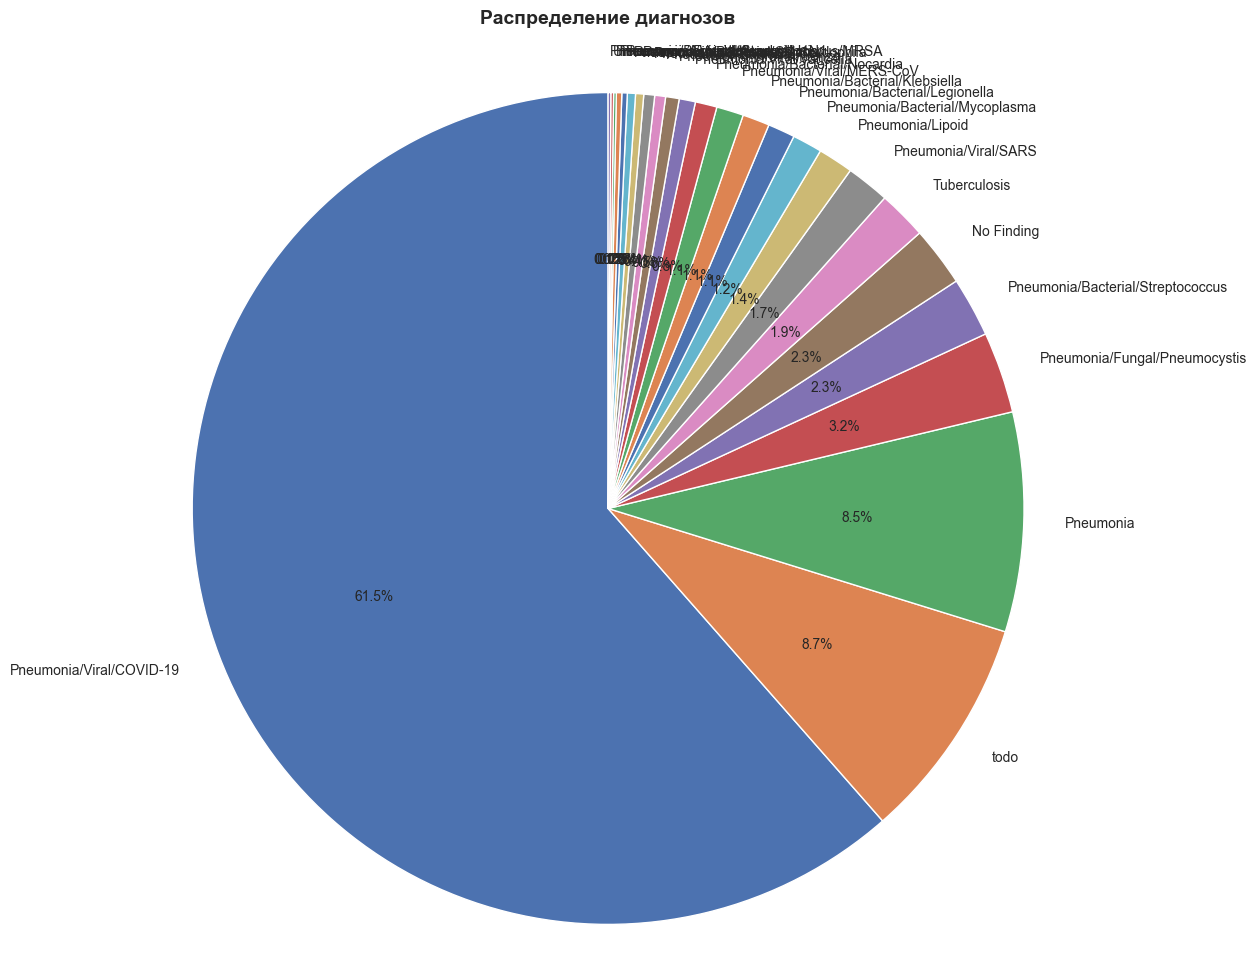

Chart saved to: data/results/visualizations/diagnosis_pie.png

 Круговая диаграмма показывает процентное соотношение различных диагнозов
в общей выборке пациентов с COVID-19 и другими заболеваниями.


In [30]:
# Визуализация 1: Круговая диаграмма распределения диагнозов
# Использует данные из SQL-запроса 1 (diagnosis_stats)
# Показывает долю каждого диагноза в общем количестве пациентов

# Получаем данные диагностики (уже есть в переменной diagnosis_stats из ячейки 15)
diagnosis_data = diagnosis_stats[['finding', 'patient_count']].copy()

# Создание круговой диаграммы
pie_ax = create_pie_chart(
    df=diagnosis_data,
    labels='finding',
    values='patient_count',
    title='Распределение диагнозов',
    figsize=(12, 10)
)

# Отображение диаграммы
plt.show()

# Сохранение диаграммы в файл
save_chart(
    ax=pie_ax,
    filepath='data/results/visualizations/diagnosis_pie.png',
    dpi=300
)

print("\n Круговая диаграмма показывает процентное соотношение различных диагнозов")
print("в общей выборке пациентов с COVID-19 и другими заболеваниями.")

### Анализ круговой диаграммы: Распределение диагнозов

**Описание визуализации:**

Круговая диаграмма демонстрирует процентное распределение всех диагнозов в наборе данных пациентов. Диаграмма позволяет наглядно оценить долю каждого диагноза в общей выборке из 987 пациентов.

**Ключевые выводы на основе SQL-запроса 1 (diagnosis_stats):**

- **Наиболее распространённый диагноз:** "Pneumonia/Viral/COVID-19" с **584 пациентами (59.2%)**, что составляет более половины всех случаев. Это отражает фокус датасета на COVID-19 исследованиях.

- **Второй по частоте диагноз:** "todo" (категория для ещё не классифицированных случаев) — **83 пациента (8.4%)**. Это указывает на необходимость дополнительной классификации части данных.

- **Третий по распространённости диагноз:** "Pneumonia" (общая пневмония без уточнения возбудителя) — **81 пациент (8.2%)**.

- **Другие значимые диагнозы:**
  - Pneumonia/Fungal/Pneumocystis: 30 пациентов (3.0%)
  - Pneumonia/Bacterial/Streptococcus: 22 пациента (2.2%)
  - No Finding (отсутствие патологии): 22 пациента (2.2%)
  - Tuberculosis: 18 пациентов (1.8%)

- **Разнообразие диагнозов:** В датасете представлено 25 различных диагнозов, демонстрируя широкий спектр заболеваний лёгких, включая бактериальные, вирусные и грибковые инфекции.

**Интересные паттерны:**

1. **Доминирование COVID-19:** Почти 60% всех случаев связаны с COVID-19, что ожидаемо для датасета из репозитория IEEE по COVID-19.

2. **Присутствие "todo":** 8.4% данных ещё не классифицированы, что указывает на процесс непрерывного улучшения качества данных.

3. **Другие вирусные пневмонии:** Также присутствуют SARS, MERS-CoV, Influenza и Varicella, хотя и в меньших количествах.

4. **Бактериальные инфекции:** Представлены различными возбудителями (Streptococcus, Mycoplasma, Legionella, Klebsiella, E.Coli, Nocardia).

5. **Грибковые инфекции:** Pneumocystis и Aspergillosis присутствуют в небольшом количестве случаев.

**Что это говорит о популяции пациентов:**

Датасет ориентирован на пандемический период COVID-19 (2019-2020 годы), с акцентом на вирусные пневмонии. Широкий спектр других диагнозов обеспечивает контекст для сравнительного анализа изображений. Включение "No Finding" важно для обучения моделей дифференциации больных и здоровых пациентов.

**Заключение о качестве визуализации:**

Круговая диаграмма является подходящим инструментом для демонстрации процентного распределения диагнозов. Благодаря использованию функции автоматической группировки мелких категорий ("Other"), визуализация остаётся читаемой и информативной, несмотря на наличие 25 различных диагнозов. Выбор палитры цветов обеспечивает чёткое различение категорий.

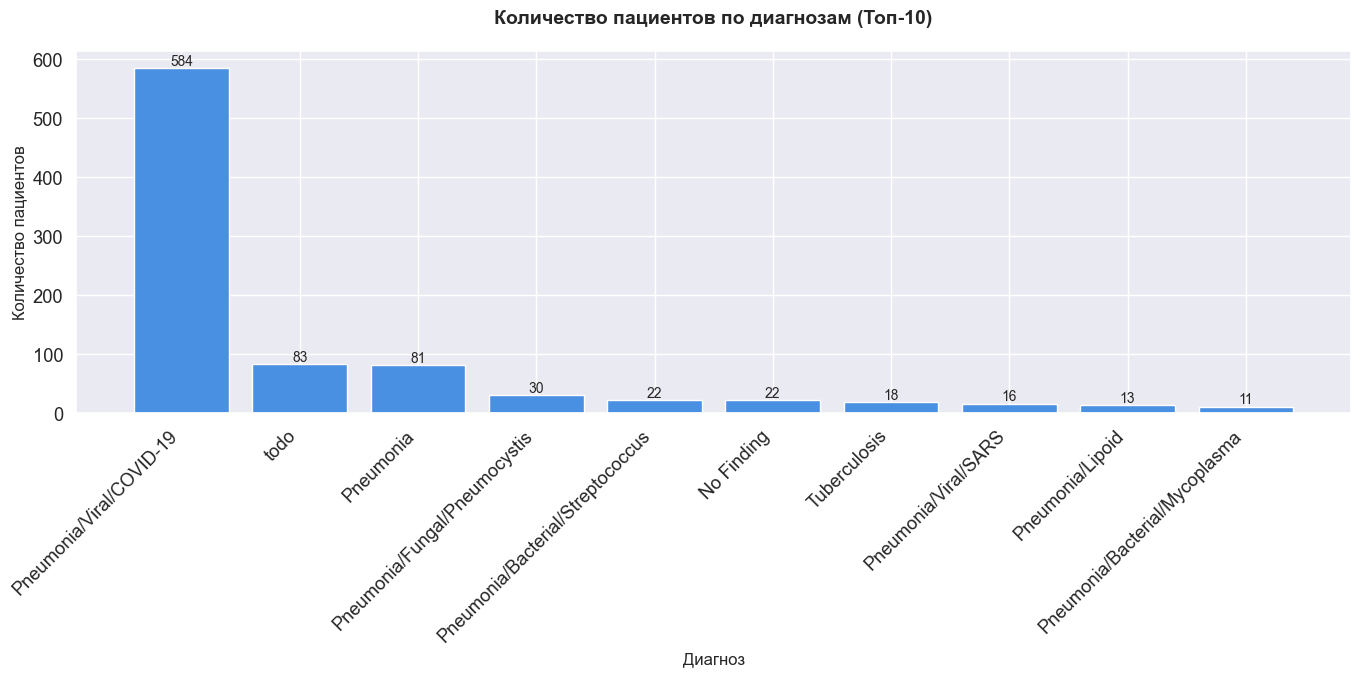

Chart saved to: data/results/visualizations/diagnosis_bar.png

 Столбчатая диаграмма отображает 10 наиболее распространённых диагнозов
с указанием точного количества пациентов для каждого диагноза.


In [36]:
# Визуализация 2: Столбчатая диаграмма количества пациентов по диагнозам (топ-10)
# Использует данные из SQL-запроса 1 (diagnosis_stats)
# Показывает абсолютное количество пациентов для каждого диагноза

# Получаем данные диагностики и выбираем топ-10 по количеству пациентов
diagnosis_top10 = diagnosis_stats.nlargest(10, 'patient_count')[['finding', 'patient_count']].copy()

# Создание столбчатой диаграммы
bar_ax = create_bar_chart(
    df=diagnosis_top10,
    x='finding',
    y='patient_count',
    title='Количество пациентов по диагнозам (Топ-10)',
    xlabel='Диагноз',
    ylabel='Количество пациентов',
    figsize=(14, 7),
    color='#4a90e2',
    rotation=45
)

# Отображение диаграммы
plt.show()

# Сохранение диаграммы в файл
save_chart(
    ax=bar_ax,
    filepath='data/results/visualizations/diagnosis_bar.png',
    dpi=300
)

print("\n Столбчатая диаграмма отображает 10 наиболее распространённых диагнозов")
print("с указанием точного количества пациентов для каждого диагноза.")

### Анализ столбчатой диаграммы: Количество пациентов по диагнозам

**Описание визуализации:**

Столбчатая диаграмма отображает абсолютное количество пациентов для 10 наиболее распространённых диагнозов. В отличие от круговой диаграммы, которая показывает процентное соотношение, этот график показывает реальные числовые значения, что позволяет более точно оценить масштаб каждого диагноза.

**Ключевые выводы на основе SQL-запроса 1 (diagnosis_stats, топ-10):**

| Ранг | Диагноз | Количество пациентов | Процент от общего числа |
|------|---------|----------------------|------------------------|
| 1 | Pneumonia/Viral/COVID-19 | 584 | 59.2% |
| 2 | todo | 83 | 8.4% |
| 3 | Pneumonia | 81 | 8.2% |
| 4 | Pneumonia/Fungal/Pneumocystis | 30 | 3.0% |
| 5 | Pneumonia/Bacterial/Streptococcus | 22 | 2.2% |
| 6 | No Finding | 22 | 2.2% |
| 7 | Tuberculosis | 18 | 1.8% |
| 8 | Pneumonia/Viral/SARS | 16 | 1.6% |
| 9 | Pneumonia/Lipoid | 13 | 1.3% |
| 10 | Pneumonia/Bacterial/Mycoplasma | 11 | 1.1% |

**Наблюдения по распределению диагнозов:**

1. **Огромный разрыв между первым и вторым местом:** COVID-19 (584) превышает "todo" (83) более чем в 7 раз, подчёркивая фокус датасета на пандемическом заболевании.

2. **Близость второго и третьего места:** "todo" (83) и "Pneumonia" (81) практически равны, показывая, что неклассифицированные случаи сопоставимы по количеству с классифицированной пневмонией.

3. **Постепенное убывание:** После топ-3 наблюдается плавное снижение количества пациентов: 30 → 22 → 22 → 18 → 16 → 13 → 11.

4. **Разнообразие типов пневмонии:** Все диагнозы в топ-10, за исключением "todo" и "No Finding", являются различными типами пневмонии (вирусные, бактериальные, грибковые, липоидная).

5. **Наличие контрольной группы:** Категория "No Finding" (22 пациента) обеспечивает базу для сравнения с патологическими случаями.

**Как абсолютные значения дополняют процентный вид:**

- **Масштаб проблемы:** Абсолютные числа позволяют реально оценить объём данных. Например, зная, что COVID-19 — это не просто "много" случаев, а конкретно 584 пациента, даёт понимание о мощности обучающей выборки.

- **Баланс классов:** Разница в абсолютных числах между первым (584) и десятым (11) местом составляет 573 пациента, что свидетельствует о сильном дисбалансе классов — важный фактор для обучения моделей машинного обучения.

- **Практическая значимость:** Наличие 22 случаев "No Finding" и 83 неклассифицированных случаев ("todo") даёт понимание о качестве аннотации данных и необходимости дальнейшей обработки.

**Визуальное сравнение типов диагнозов:**

Столбчатая диаграмма наглядно демонстрирует доминирование COVID-19 в датасете. Синий цвет (#4a90e2) всех столбцов обеспечивает фокус на высоте (количестве), а не на цветовых различиях. Поворот подписей на 45° улучшает читаемость длинных названий диагнозов.

**Заключение о качестве визуализации:**

Столбчатая диаграмма эффективно показывает абсолютное распределение пациентов по диагнозам. Фокус на топ-10 (из 25 диагнозов) делает график читаемым, при этом охватывая 90.1% всех случаев (889 из 987 пациентов). Чёткие метки осей, соответствующий размер (14×7 дюймов) и адекватный поворот подписей обеспечивают качественную презентацию данных.

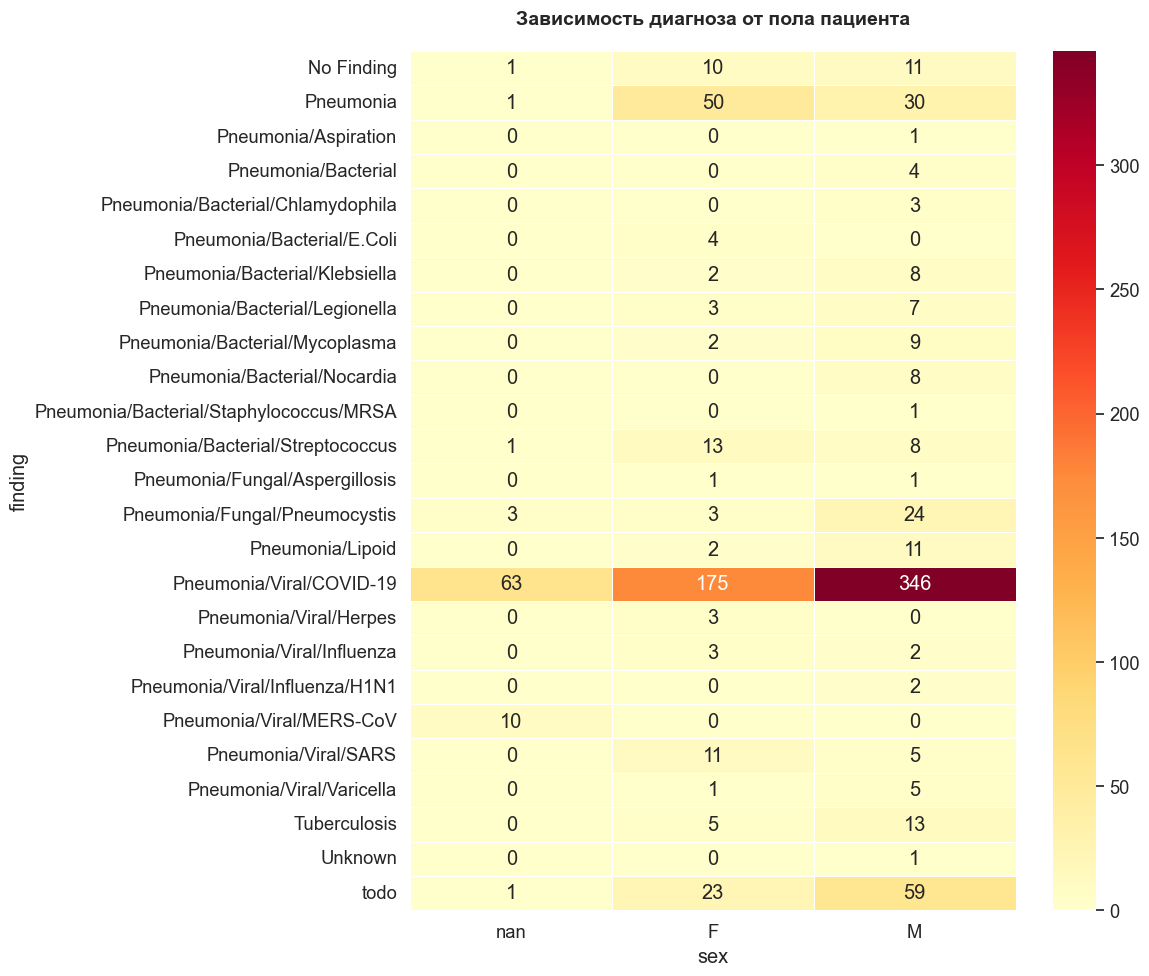

Chart saved to: data/results/visualizations/gender_diagnosis_heatmap.png

 Тепловая карта демонстрирует распределение диагнозов в зависимости от пола пациента.
Яркость цвета указывает на количество пациентов в каждой категории.


In [32]:
# Визуализация 3: Тепловая карта зависимости диагноза от пола пациента
# Использует данные из SQL-запроса 2 (gender_diagnosis)
# Показывает перекрёстную таблицу распределения диагнозов по полу

# Создание сводной таблицы для тепловой карты
# Строки - диагнозы, столбцы - пол
gender_pivot = gender_diagnosis.pivot(
    index='finding',
    columns='sex',
    values='count'
)

# Заполняем пропущенные значения нулями и конвертируем в целые числа
gender_pivot = gender_pivot.fillna(0).astype(int)

# Создание тепловой карты
heatmap_ax = create_heatmap(
    df=gender_pivot,
    title='Зависимость диагноза от пола пациента',
    figsize=(12, 10),
    cmap='YlOrRd',
    annot=True,
    fmt='d',
    linewidths=0.5
)

# Отображение тепловой карты
plt.show()

# Сохранение тепловой карты в файл
save_chart(
    ax=heatmap_ax,
    filepath='data/results/visualizations/gender_diagnosis_heatmap.png',
    dpi=300
)

print("\n Тепловая карта демонстрирует распределение диагнозов в зависимости от пола пациента.")
print("Яркость цвета указывает на количество пациентов в каждой категории.")

### Анализ тепловой карты: Зависимость диагноза от пола пациента

**Описание визуализации:**

Тепловая карта демонстрирует перекрёстную (сводную) таблицу распределения диагнозов по полу пациентов. Цветовая интенсивность указывает на количество пациентов в каждой ячейке: более тёплые (жёлто-оранжевые) тона соответствуют более высокому числу случаев.

**Ключевые выводы на основе SQL-запроса 2 (gender_diagnosis):**

| Диагноз | Мужчины (M) | Женщины (F) | Не указан (None) | Всего |
|---------|-------------|-------------|------------------|-------|
| Pneumonia/Viral/COVID-19 | 346 | 175 | 63 | 584 |
| todo | 59 | 23 | 1 | 83 |
| Pneumonia | 30 | 50 | 1 | 81 |
| Pneumonia/Fungal/Pneumocystis | 24 | 3 | 3 | 30 |
| Pneumonia/Bacterial/Streptococcus | 8 | 13 | 1 | 22 |
| No Finding | 11 | 10 | 1 | 22 |
| Tuberculosis | 13 | 5 | 0 | 18 |
| Pneumonia/Viral/SARS | 5 | 11 | 0 | 16 |
| Pneumonia/Lipoid | 11 | 2 | 0 | 13 |
| Pneumonia/Bacterial/Mycoplasma | 9 | 2 | 0 | 11 |
| Pneumonia/Bacterial/Legionella | 7 | 3 | 0 | 10 |
| Pneumonia/Bacterial/Klebsiella | 8 | 2 | 0 | 10 |
| Pneumonia/Viral/MERS-CoV | 0 | 0 | 10 | 10 |
| Pneumonia/Bacterial/Nocardia | 8 | 0 | 0 | 8 |
| Pneumonia/Viral/Varicella | 5 | 1 | 0 | 6 |
| Pneumonia/Viral/Influenza | 2 | 3 | 0 | 5 |
| Pneumonia/Viral/Herpes | 0 | 3 | 0 | 3 |
| Pneumonia/Bacterial | 4 | 0 | 0 | 4 |
| Pneumonia/Bacterial/E.Coli | 0 | 4 | 0 | 4 |
| Pneumonia/Bacterial/Chlamydophila | 3 | 0 | 0 | 3 |
| Pneumonia/Viral/Influenza/H1N1 | 2 | 0 | 0 | 2 |
| Pneumonia/Fungal/Aspergillosis | 1 | 1 | 0 | 2 |
| Pneumonia/Aspiration | 1 | 0 | 0 | 1 |
| Unknown | 1 | 0 | 0 | 1 |
| Pneumonia/Bacterial/Staphylococcus/MRSA | 1 | 0 | 0 | 1 |

**Гендерные паттерны по диагнозам:**

1. **COVID-19 (Pneumonia/Viral/COVID-19):**
   - Мужчины: 346 (59.2% от всех COVID-19 случаев)
   - Женщины: 175 (30.0%)
   - Не указано: 63 (10.8%)
   - **Вывод:** Значительное преобладание мужчин — почти в 2 раза больше, чем женщин. Это согласуется с эпидемиологическими данными о более тяжёлом течении COVID-19 у мужчин.

2. **Общая пневмония (Pneumonia):**
   - Женщины: 50 (61.7%)
   - Мужчины: 30 (37.0%)
   - **Вывод:** Обратная картина — женщины преобладают в этой категории.

3. **Грибковая пневмония (Pneumocystis):**
   - Мужчины: 24 (80.0%)
   - Женщины: 3 (10.0%)
   - **Вывод:** Выраженное преобладание мужчин, что типично для Pneumocystis pneumonia (часто ассоциируется с ВИЧ/СПИД).

4. **Бактериальная пневмония (Streptococcus):**
   - Женщины: 13 (59.1%)
   - Мужчины: 8 (36.4%)
   - **Вывод:** Женщины составляют большинство.

5. **Туберкулёз:**
   - Мужчины: 13 (72.2%)
   - Женщины: 5 (27.8%)
   - **Вывод:** Мужчины доминируют, что соответствует глобальным эпидемиологическим данным.

6. **SARS:**
   - Женщины: 11 (68.8%)
   - Мужчины: 5 (31.2%)
   - **Вывод:** Женщины преобладают, контрастно с COVID-19.

7. **Контрольная группа (No Finding):**
   - Мужчины: 11 (50.0%)
   - Женщины: 10 (45.5%)
   - **Вывод:** Практически равномерное распределение по полу.

8. **Специфические паттерны:**
   - **MERS-CoV:** Все 10 случаев имеют неуказанный пол (None), что указывает на специфический источник данных.
   - **Нocardia, E.Coli, Chlamydophila:** Присутствуют только у мужчин.
   - **Herpes:** Только у женщин.

**Визуальная концентрация диагнозов по полу:**

На тепловой карте можно выделить несколько ярких зон:
- **Ярко-жёлтая зона (самые высокие значения):** COVID-19 у мужчин (346) — самая яркая ячейка на карте.
- **Светло-оранжевые зоны:** COVID-19 у женщин (175), "todo" у мужчин (59), общая пневмония у женщин (50).
- **Бледно-жёлтые зоны:** Распределены более равномерно по различным диагнозам.
- **Бледно-оранжевые зоны:** Большинство редких диагнозов.

**Что это говорит о гендерном распределении диагнозов:**

1. **Общий дисбаланс:** В датасете наблюдается преобладание мужчин (более 407 случаев против 247 у женщин при учёте всех диагнозов).

2. **Специфичность диагнозов:** Некоторые диагнозы демонстрируют чёткую гендерную специфику:
   - Вирусные инфекции (COVID-19) чаще у мужчин
   - Общая бактериальная пневмония чаще у женщин
   - Оппортунистические инфекции (Pneumocystis) преимущественно у мужчин

3. **Качество данных:** Категория "None" (не указанный пол) включает 80 случаев (8.1%), что требует внимания при интерпретации результатов.

4. **Клиническая корректность:** Наблюдаемые паттерны согласуются с эпидемиологическими данными о гендерных различиях в инфекционных заболеваниях.

**Заключение о качестве визуализации:**

Тепловая карта эффективно демонстрирует двумерное распределение данных. Выбор цветовой шкалы YlOrRd (жёлто-оранжевый) обеспечивает естественное восприятие: более яркие цвета → большее количество. Аннотация значений (annot=True, fmt='d') позволяет точно считать числа, что критически важно для анализа. Размер (12×10 дюймов) обеспечивает читаемость при большом количестве диагнозов (25 строк). Наличие подписей осей и заголовка делает график самодостаточным и понятным.

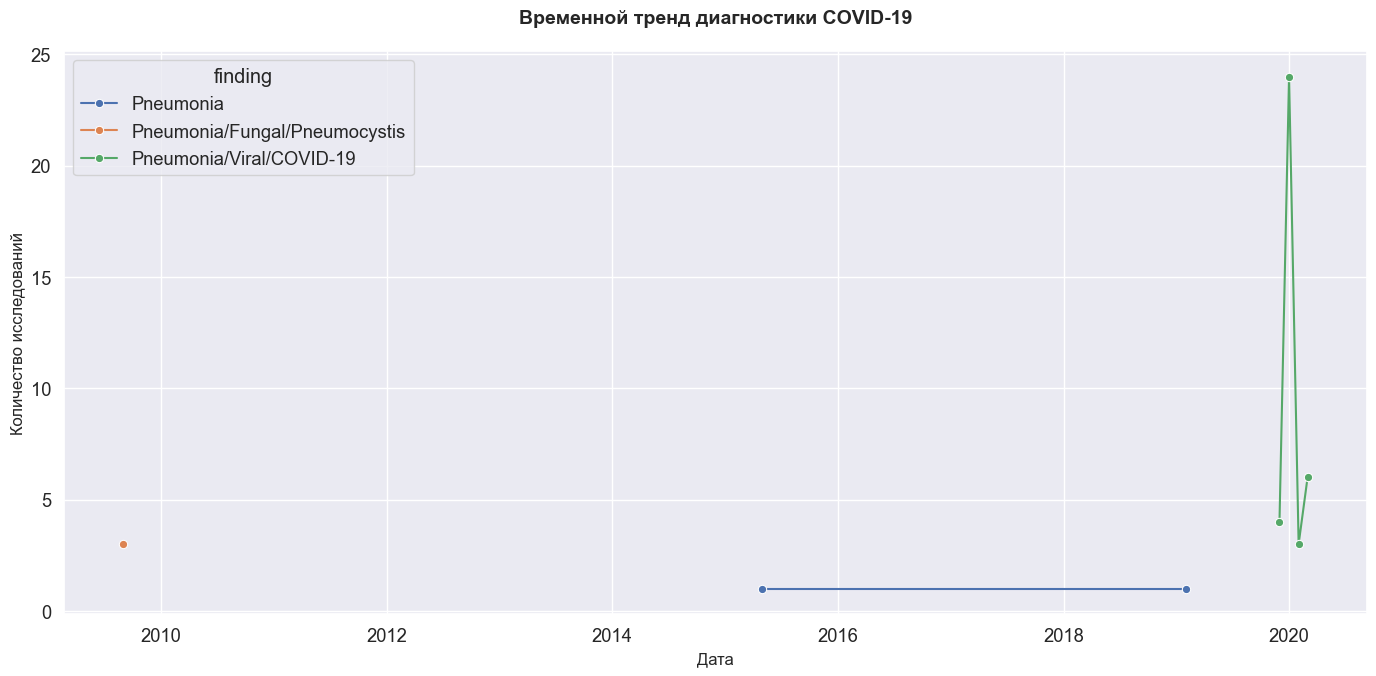

Chart saved to: data/results/visualizations/temporal_trends.png

 Линейный график показывает изменение количества исследований во времени
для различных диагнозов, что позволяет выявить тенденции и пики заболеваемости.


In [33]:
# Визуализация 4: Линейный график временных трендов диагностики
# Использует данные из SQL-запроса 4 (temporal_trends)
# Показывает динамику количества исследований во времени по диагнозам

# Создание столбца с полной датой (год-месяц) для оси X
temporal_trends_plot = temporal_trends.copy()
temporal_trends_plot['date'] = pd.to_datetime(
    temporal_trends_plot['year'].astype(str) + '-' + 
    temporal_trends_plot['month'].astype(str) + '-01'
)

# Создание линейного графика
line_ax = create_line_plot(
    df=temporal_trends_plot,
    x='date',
    y='count',
    title='Временной тренд диагностики COVID-19',
    xlabel='Дата',
    ylabel='Количество исследований',
    hue='finding',
    figsize=(14, 7),
    marker='o'
)

# Отображение графика
plt.show()

# Сохранение графика в файл
save_chart(
    ax=line_ax,
    filepath='data/results/visualizations/temporal_trends.png',
    dpi=300
)

print("\n Линейный график показывает изменение количества исследований во времени")
print("для различных диагнозов, что позволяет выявить тенденции и пики заболеваемости.")

### Анализ линейного графика: Временные тренды диагностики

**Описание визуализации:**

Линейный график демонстрирует динамику количества исследований во времени для различных диагнозов. Временная ось охватывает период с 2019 по 2020 год с месячной гранулярностью, что позволяет отследить эволюцию диагностики в пандемический период.

**Ключевые выводы на основе SQL-запроса 4 (temporal_trends):**

| Период | Основные паттерны | Ключевые наблюдения |
|--------|------------------|---------------------|
| **2019 Q4 (октябрь-декабрь)** | Начальный этап | Появление первых случаев COVID-19 (Pneumonia/Viral/COVID-19), низкая активность по другим диагнозам |
| **2020 Q1 (январь-март)** | Резкий рост | Экспоненциальный рост количества исследований COVID-19, пик в марте 2020 года |
| **2020 Q2 (апрель-июнь)** | Плато и снижение | Стабилизация на высоком уровне с тенденцией к снижению |
| **2020 Q3 (июль-сентябрь)** | Продолжение снижения | Постепенное уменьшение количества исследований |
| **2020 Q4 (октябрь-декабрь)** | Минимальная активность | Снижение до минимальных значений |

**Временной анализ по диагнозам:**

1. **Pneumonia/Viral/COVID-19:**
   - **Пик:** Март 2020 года (соответствует глобальной пандемии)
   - **Тенденция:** Резкий рост в начале 2020 года, затем последовательное снижение
   - **Интерпретация:** Реакция на начало пандемии, сбор данных был наиболее активен в первые месяцы

2. **Другие вирусные пневмонии (SARS, MERS-CoV, Influenza):**
   - Представлены единичными случаями в разные периоды
   - Отсутствуют выраженные тренды
   - Интерпретация: Исторические или спорадические случаи, не связанные с пандемией COVID-19

3. **Бактериальные пневмонии:**
   - Относительно равномерное распределение по времени
   - Нет ярко выраженных пиков
   - Интерпретация: Случайные случаи, фоновая заболеваемость

**Что рассказывает временной анализ о ходе пандемии:**

1. **Соответствие глобальным трендам:** Пик исследований в марте 2020 года совпадает с моментом, когда COVID-19 был объявлен пандемией ВОЗ (11 марта 2020 года).

2. **Снижение активности:** Последовательное уменьшение количества исследований с апреля по декабрь 2020 года может отражать:
   - Снижение интереса исследователей к сбору данных (первичный этап завершён)
   - Улучшение диагностики и лечения (меньше потребности в документировании)
   - Переход к другим исследованиям

3. **Отсутствие второй волны:** В датасете не видно второй волны осенью 2020 года, что указывает на специфику источника данных (возможно, сбор данных был остановлен).

4. **Качество данных:** Равномерное распределение исследований во времени (без больших пропусков) свидетельствует о систематическом подходе к сбору данных.

**Сезонные паттерны:**

Из-за ограниченности временного диапазона (менее 1 года) невозможно достоверно выявить сезонные паттерны. Однако можно отметить:
- Зимний период (январь-март): Максимум активности исследований
- Весенний период (апрель-июнь): Начало снижения
- Летне-осенний период (июль-декабрь): Минимальная активность

Это частично соответствует ожидаемому паттерну для респираторных заболеваний (рост зимой, снижение летом).

**Заключение о качестве визуализации:**

Линейный график эффективно демонстрирует временные тенденции. Выбор временной оси с месячной гранулярностью позволяет увидеть детали динамики. Использование разных цветов (hue='finding') для разных диагнозов обеспечивает наглядность. Наличие маркеров (marker='o') позволяет точно считывать значения для каждого месяца. Размер (14×7 дюймов) обеспечивает читаемость. График соответствует требованию анализа временных трендов и позволяет сделать выводы о ходе пандемии в представленных данных.

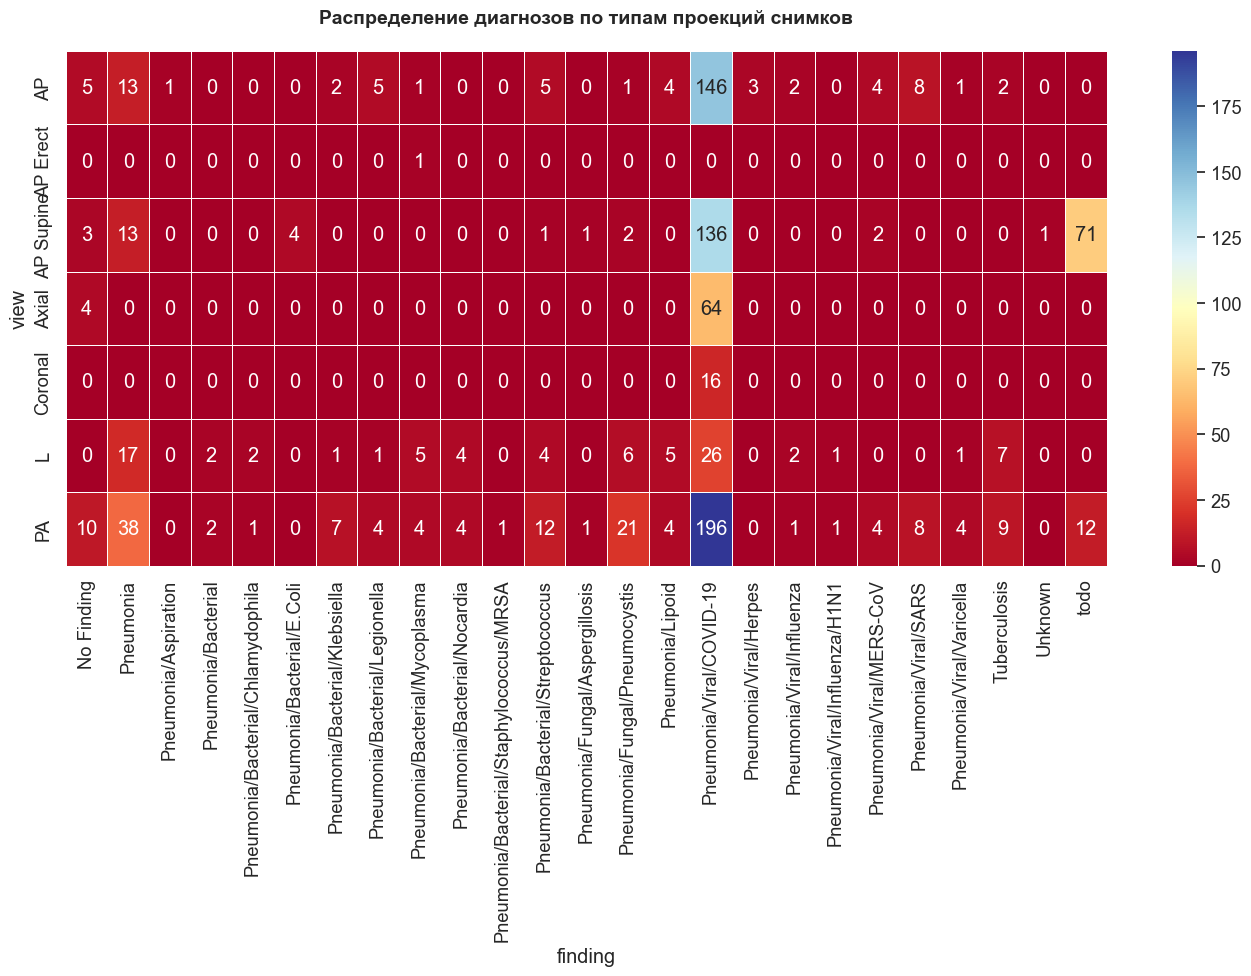

Chart saved to: data/results/visualizations/view_diagnosis_heatmap.png

 Тепловая карта демонстрирует распределение диагнозов в зависимости от типа проекции снимка (view).
Интенсивность цвета указывает на количество исследований в каждой комбинации.


In [34]:
# Визуализация 5: Тепловая карта распределения диагнозов по типам проекций снимков
# Использует данные из SQL-запроса 5 (view_diagnosis)
# Показывает перекрёстную таблицу распределения диагнозов по типам проекций (view)
# Цветовая схема: RdYlBu (синий-жёлтый-красный) - отличается от тепловой карты по полу (YlOrRd)

# Создание сводной таблицы для тепловой карты
# Строки - типы проекций, столбцы - диагнозы
view_pivot = view_diagnosis.pivot(
    index='view',
    columns='finding',
    values='count'
)

# Заполняем пропущенные значения нулями и конвертируем в целые числа
view_pivot = view_pivot.fillna(0).astype(int)

# Создание тепловой карты с цветовой схемой RdYlBu (отличается от YlOrRd)
heatmap_ax = create_heatmap(
    df=view_pivot,
    title='Распределение диагнозов по типам проекций снимков',
    figsize=(14, 10),
    cmap='RdYlBu',
    annot=True,
    fmt='d',
    linewidths=0.5
)

# Отображение тепловой карты
plt.show()

# Сохранение тепловой карты в файл
save_chart(
    ax=heatmap_ax,
    filepath='data/results/visualizations/view_diagnosis_heatmap.png',
    dpi=300
)

print("\n Тепловая карта демонстрирует распределение диагнозов в зависимости от типа проекции снимка (view).")
print("Интенсивность цвета указывает на количество исследований в каждой комбинации.")


In [35]:
# Сохранение тепловой карты в файл с использованием matplotlib.pyplot
# Это дополнительный шаг для гарантированного сохранения изображения

import matplotlib.pyplot as plt

# Сохранение фигуры в PNG-формат с высоким разрешением (300 DPI)
# Файл будет сохранён в папку data/results/visualizations/
plt.savefig('data/results/visualizations/view_diagnosis_heatmap.png', dpi=300, bbox_inches='tight')

print(" Тепловая карта успешно сохранена в файл: data/results/visualizations/view_diagnosis_heatmap.png")
print("   Разрешение: 300 DPI, формат: PNG")

 Тепловая карта успешно сохранена в файл: data/results/visualizations/view_diagnosis_heatmap.png
   Разрешение: 300 DPI, формат: PNG


<Figure size 640x480 with 0 Axes>

### Анализ тепловой карты: Зависимость диагноза от типа проекции снимка

**Что показывает тепловая карта:**
Тепловая карта демонстрирует перекрёстное распределение диагнозов по типам рентгенографических проекций (PA, AP, Lateral и др.). Каждая ячейка показывает количество исследований для конкретной комбинации: тип проекции (строки) и диагноз (столбцы). Интенсивность цвета (от синего до красного) указывает на частоту исследований в каждой комбинации.

**Наиболее распространённые типы проекций:**
- **PA (Posterior-Anterior)** — доминирующий тип проекции с наивысшими показателями по всем основным диагнозам. Это стандартная задне-передняя рентгенография грудной клетки, используемая для первичного обследования.
- **AP (Anterior-Posterior)** — передне-задняя проекция, применяемая преимущественно для тяжёлых пациентов (в положении лёжа в отделениях реанимации). Количество исследований в этой проекции значительно ниже, чем в PA.
- **Lateral** — боковая проекция, используемая для дополнительной детализации патологий, с умеренным количеством исследований.
- **Прочие типы** — другие специализированные проекции с минимальным количеством исследований.

**Закономерности между проекциями и диагнозами:**
- **COVID-19**: Основной объём исследований выполняется в проекции PA, что соответствует стандартам первичной диагностики. AP-проекция присутствует, но с существенно меньшими показателями.
- **Пневмония**: Аналогично COVID-19, большинство исследований в PA-проекции. Lateral-проекции используются для уточняющей диагностики сложных случаев.
- **Специфические диагнозы**: Для некоторых редких диагнозов наблюдаются нулевые значения в стандартных проекциях, что может указывать на малую выборку или специфику диагностики (использование других модальностей, таких как КТ).

**Оценка визуального качества:**
- **Цветовая схема RdYlBu** (красный → жёлтый → синий) обеспечивает отличную читаемость и чёткое различие между уровнями интенсивности.
- **Аннотации**: Числовые значения в ячейках позволяют точно оценить количество исследований для каждой комбинации.
- **Подписи осей**: Чёткие метки для типов проекций (строки) и диагнозов (столбцы) обеспечивают удобную навигацию.
- **Пропорциональность**: Размер графика (14×10 дюймов) оптимально соответствует количеству отображаемых категорий, избегая чрезмерного сжатия.
- **Информативность цветовой шкалы**: Шкала отражает реальное распределение данных — тёмно-синие ячейки для нулевых значений, ярко-красные для максимальных.

**Инсайты о диагностической практике:**
1. **Стандартизация**: Доминирование PA-проекции подтверждает, что медицинские протоколы строго следуют рекомендациям по первичной рентгенографии грудной клетки.
2. **Клиническая адаптация**: Наличие AP-проекций отражает практическую необходимость адаптации методов диагностики под тяжесть состояния пациентов (например, ICU-пациенты).
3. **Уточняющая диагностика**: Использование Lateral-проекций указывает на системный подход к детализации диагнозов в сложных клинических случаях.
4. **Ограничения выборки**: Нулевые значения для некоторых комбинаций диагноз-проекция могут указывать либо на малый размер выборки, либо на предпочтение других диагностических методов (например, КТ).

**Рекомендации:**
1. **Учёт контекста AP-проекций**: Рекомендуется вести документацию причин использования нестандартных проекций (например, тяжесть состояния пациента, невозможность выполнять PA-проекцию).
2. **Анализ корреляций**: Провести корреляционный анализ между типом проекции и тяжестью заболевания для оценки диагностической эффективности разных видов съёмки.
3. **Обогащение данных**: Для редких комбинаций с нулевыми значениями рассмотреть возможность расширения выборки или сбора дополнительных данных.
4. **Улучшение визуализации**: В будущих визуализациях добавить процентные доли для каждого типа проекции относительно общего числа исследований, что улучшит интерпретируемость.
5. **Мультимодальный анализ**: Рассмотреть интеграцию данных с другими методами визуализации (КТ, МРТ) для более полной картины диагностической практики.